<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_fastai_xla_extensions_MNIST_TPU_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI XLA Extensions MNIST Demo


## How to use

### Configure the Pytorch XLA package 

The Pytorch xla package requires an environment supporting TPUs (Kaggle kernels, GCP or Colab environments required)

If running on Colab, make sure the Runtime Type is set to TPU.


In [1]:
#hide_input
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
#hide
#colab
!curl -s https://course.fast.ai/setup/colab | bash 

Updating fastai...
Done.


In [3]:
#hide_output
#colab
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  88189      0 --:--:-- --:--:-- --:--:-- 88189
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████████| 61kB 2.8MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
/ [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     


Install fastai2 and the fastai_xla_extensions packages

In [4]:
#hide_output
#colab
!pip install fastai2 --upgrade > /dev/null

In [5]:
#hide_output
#ci
!pip install git+https://github.com/butchland/fastai_xla_extensions > /dev/null

  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-grx0krw4


### Import the libraries
Import the fastai2 and fastai_xla_extensions libraries

In [2]:
#colab
import fastai_xla_extensions.core

**IMPORTANT: Make sure to import fastai_xla_extensions.core BEFORE importing fastai2 libraries** 

If you don't, fastai2 will not default to use tpu device but will instead use the cpu.

In [3]:
from fastai2.vision.all import *

### Example
Build a MNIST classifier -- adapted from fastai course [Lesson 4 notebook](https://github.com/fastai/course-v4/blob/master/nbs/04_mnist_basics.ipynb)

Load MNIST dataset 

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
#hide
Path.BASE_PATH = path

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [6]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training',valid_name='testing'),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [7]:
#colab
datablock.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/5/27296.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/5/27296.png
    applying parent_label gives
      5
    applying Categorize gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(5))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(5))
    applying Resize gives
      (PILImage mode=RGB size=28x2

Create the dataloader

In [8]:
dls = datablock.dataloaders(path,bs=256)

In [9]:
#colab
dls.device

device(type='xla', index=1)

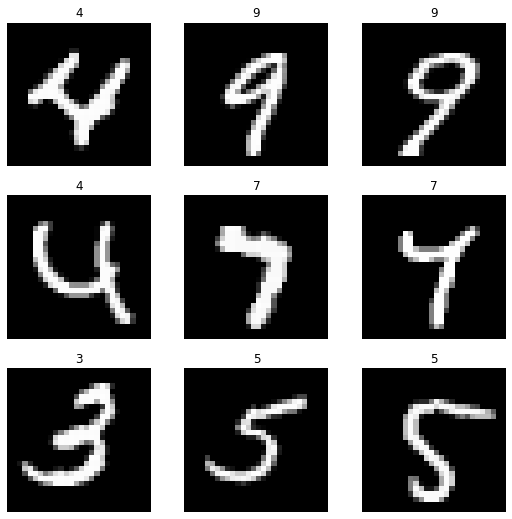

In [10]:
#colab
dls.show_batch()

Create a Fastai CNN Learner

In [11]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy)
                      

Using the `lr_find` works 

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.019054606556892395)

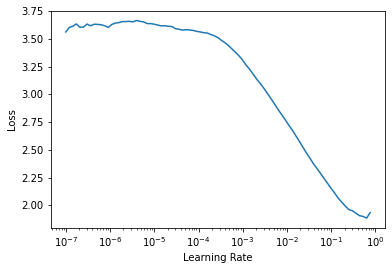

In [12]:
#colab
learner.lr_find()

Fine tune model


In [13]:
#colab
learner.fine_tune(1, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.557857,0.296880,0.902700,01:35


epoch,train_loss,valid_loss,accuracy,time
0,0.065336,0.041782,0.988100,01:32


Unfreeze the model

In [14]:
#colab
learner.unfreeze()

Run the LR Finder again. 

_(Something wrong with the results. Still need to debug this.)_

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.3182567499825382e-06)

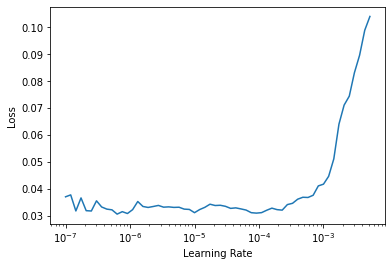

In [15]:
#colab
learner.lr_find()

Further fine-tuning

In [16]:
#colab
learner.fit_one_cycle(1,slice(7e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.030223,0.031509,0.990500,01:31


In [17]:
#hide
#colab
learner.save('stage-1')

In [18]:
#hide
#colab
learner.load('stage-1')

Model params are using TPU

In [19]:
#colab
list(learner.model.parameters())[0].device

device(type='xla', index=1)

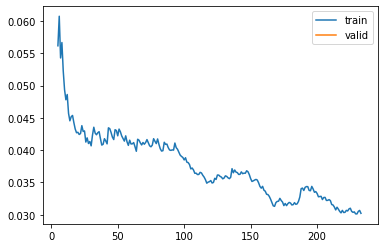

In [20]:
learner.recorder.plot_loss()

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=1.9054607491852948e-06)

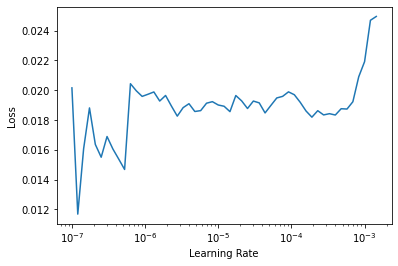

In [22]:
learner.lr_find()

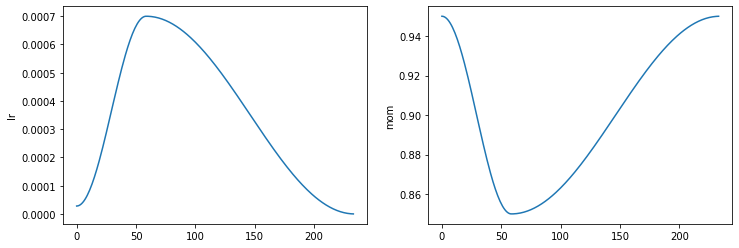

In [21]:
#colab
learner.recorder.plot_sched()

In [23]:
#colab
learner.fit_one_cycle(4,lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.017828,0.030334,0.991100,01:28
1,0.015855,0.030407,0.991400,01:25
2,0.013861,0.030466,0.991000,01:23
3,0.011044,0.031286,0.991000,01:23


In [24]:
#colab
learner.fit_one_cycle(4,lr_max=slice(4e-7,5e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.009774,0.030708,0.991300,01:22
1,0.010599,0.031640,0.991200,01:21
2,0.010144,0.031602,0.991500,01:21
3,0.008758,0.031127,0.991000,01:21


Plot loss seems to be working fine.

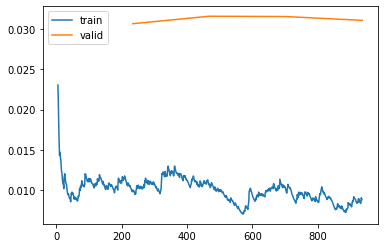

In [25]:
#colab
learner.recorder.plot_loss()

In [27]:
interp = ClassificationInterpretation.from_learner(learner)

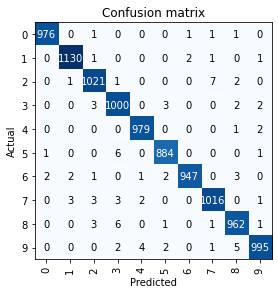

In [28]:
interp.plot_confusion_matrix()

In [29]:
interp.most_confused(4)

[('2', '7', 7), ('5', '3', 6), ('8', '3', 6), ('9', '8', 5), ('9', '4', 4)]

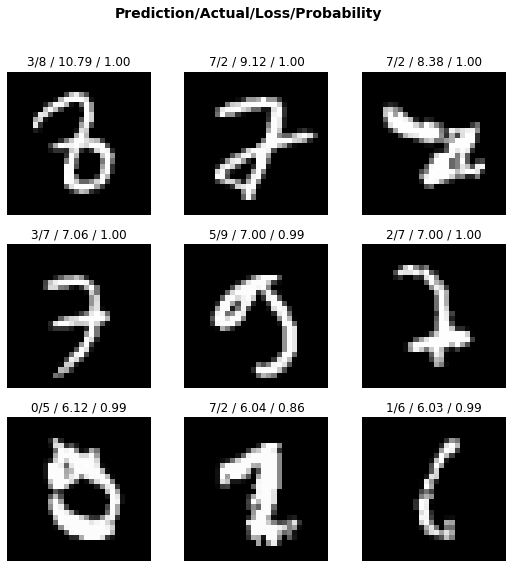

In [30]:
interp.plot_top_losses(9)